# Find the directions for extended projects on TNG50

- We need to build 200 Mpc lightcones with a large(?) enough angular diameter. 
- Find the optimal (or maximal) sampling directions

In [2]:
import numpy as np
import pandas as pd
import glob
import sys
import h5py
#from netCDF4 import Dataset
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import pyarrow as pa
import pyarrow.parquet as pq

from functools import reduce
import operator
import gc

In [3]:
# plot settings
plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

## [1] Self Mirroring Grid 

#### Raw Grid

In [36]:
# Define the range for each coordinate
range_vals = np.arange(-10, 11)  # from -4 to 4 inclusive

# Create a meshgrid of x, y, z coordinates
x, y, z = np.meshgrid(range_vals, range_vals, range_vals)

# Flatten the arrays and combine into a DataFrame
rawdf = pd.DataFrame({
    'x': x.flatten(),
    'y': y.flatten(),
    'z': z.flatten()
})

In [37]:
rawdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9261 entries, 0 to 9260
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       9261 non-null   int64
 1   y       9261 non-null   int64
 2   z       9261 non-null   int64
dtypes: int64(3)
memory usage: 217.2 KB


In [38]:
9*9*9

729

In [39]:
#rawdf.head(20)

#### Filter Ball Grid

In [40]:
# Compute Pythagorean distance from the origin
rawdf['distance'] = np.sqrt(rawdf['x']**2 + rawdf['y']**2 + rawdf['z']**2)

# Filter the DataFrame
df = rawdf[(rawdf['distance'] < 4.0) & (rawdf['distance'] > 0.0)].reset_index(drop=True)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   x         250 non-null    int64  
 1   y         250 non-null    int64  
 2   z         250 non-null    int64  
 3   distance  250 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 7.9 KB


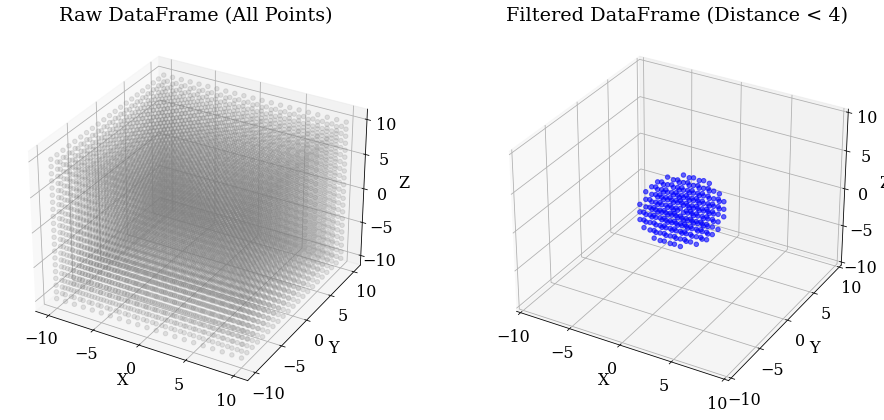

In [72]:
# --- Plotting both rawdf and df ---
fig = plt.figure(figsize=(14, 6))

# Original points (rawdf)
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(rawdf['x'], rawdf['y'], rawdf['z'], alpha=0.2, color='gray')
ax1.set_title('Raw DataFrame (All Points)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Filtered points (df)
ax2 = fig.add_subplot(122, projection='3d')
# Set axis limits to range [-4, 4]
ax2.set_xlim(-10, 10)
ax2.set_ylim(-10, 10)
ax2.set_zlim(-10, 10)
ax2.scatter(df['x'], df['y'], df['z'], alpha=0.6, color='blue')
ax2.set_title('Filtered DataFrame (Distance < 4)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.tight_layout()
plt.show()

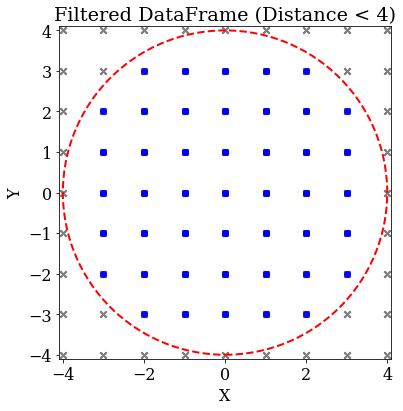

In [43]:
# plot settings
plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'
from matplotlib.patches import Circle

# --- Plotting both rawdf and df ---
fig = plt.figure(figsize=(14, 6))

# Filtered points (df)
ax1 = fig.add_subplot(121)
ax1.scatter(rawdf['x'], rawdf['y'], alpha=0.6, color='gray', marker='x')
ax1.scatter(df['x'], df['y'], alpha=0.6, color='blue')
ax1.set_title('Filtered DataFrame (Distance < 4)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

# Set axis limits to range [-4, 4]
ax1.set_xlim(-4.1, 4.1)
ax1.set_ylim(-4.1, 4.1)
ax1.set_aspect('equal')  # Equal scale for x and y axes

# Add a circle with radius 4.0 centered at (0, 0)
circle = Circle((0, 0), 4.0, color='red', fill=False, linewidth=2, linestyle='--')
ax1.add_patch(circle)

plt.tight_layout()
plt.show()

In [44]:
# Ensure radius column is present (optional if already calculated)
df['r'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)

# Compute theta (azimuthal angle, in radians)
df['phi'] = np.arctan2(df['y'], df['x'])

# Compute phi (polar angle, in radians), avoiding division by zero
df['theta'] = np.arccos(df['z'] / df['r'])

In [45]:
df['costheta'] = np.cos(df['theta'])

In [46]:
np.arctan2(0.0, 1.0),np.arctan2(1.0, 0.0)/np.pi,np.arctan2(0.0, -1.0)/np.pi,np.arctan2(-1.0, 0.0)/np.pi

(0.0, 0.5, 1.0, -0.5)

In [47]:
df.head()

,x,y,z,distance,r,phi,theta,costheta
0,-2,-3,-1,3.741657,3.741657,-2.158799,1.841346,-2.672612e-01
1,-2,-3,0,3.605551,3.605551,-2.158799,1.570796,6.123234e-17
2,-2,-3,1,3.741657,3.741657,-2.158799,1.300247,2.672612e-01
3,-1,-3,-2,3.741657,3.741657,-1.892547,2.134739,-5.345225e-01
4,-1,-3,-1,3.316625,3.316625,-1.892547,1.877074,-3.015113e-01


In [48]:
df.describe()

,x,y,z,distance,r,phi,theta,costheta
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,2.500000e+02
mean,0.000000,0.000000,0.000000,2.938243,2.938243,0.238761,1.570796,1.065814e-17
std,1.751649,1.751649,1.751649,0.732718,0.732718,1.793022,0.686839,5.785084e-01
min,-3.000000,-3.000000,-3.000000,1.000000,1.000000,-2.819842,0.000000,-1.000000e+00
25%,-1.000000,-1.000000,-1.000000,2.449490,2.449490,-1.249046,1.006854,-5.345225e-01
50%,0.000000,0.000000,0.000000,3.162278,3.162278,0.000000,1.570796,6.123234e-17
75%,1.000000,1.000000,1.000000,3.605551,3.605551,1.570796,2.134739,5.345225e-01
max,3.000000,3.000000,3.000000,3.741657,3.741657,3.141593,3.141593,1.000000e+00


In [49]:
# plot settings
plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

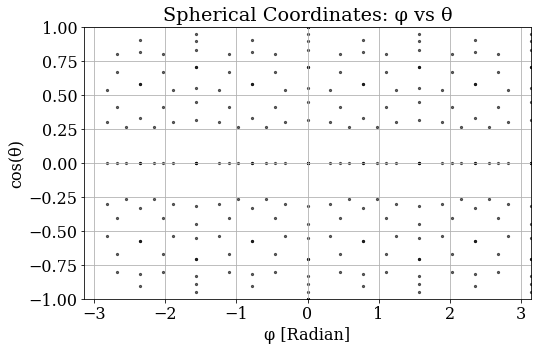

In [50]:
# Optional: convert radians to degrees for readability
theta_deg = np.degrees(df['theta'])
phi_deg = np.degrees(df['phi'])

# Create the scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(df['phi'], df['costheta'], s=5, c='black', alpha=0.6)

# Customize axes
plt.xlabel('φ [Radian]')
plt.ylabel('cos(θ)')
plt.title('Spherical Coordinates: φ vs θ')
plt.xlim(-np.pi, np.pi)
plt.ylim(-1, 1)
ax1.set_aspect('equal')  # Equal scale for x and y axes
plt.grid(True)

plt.show()

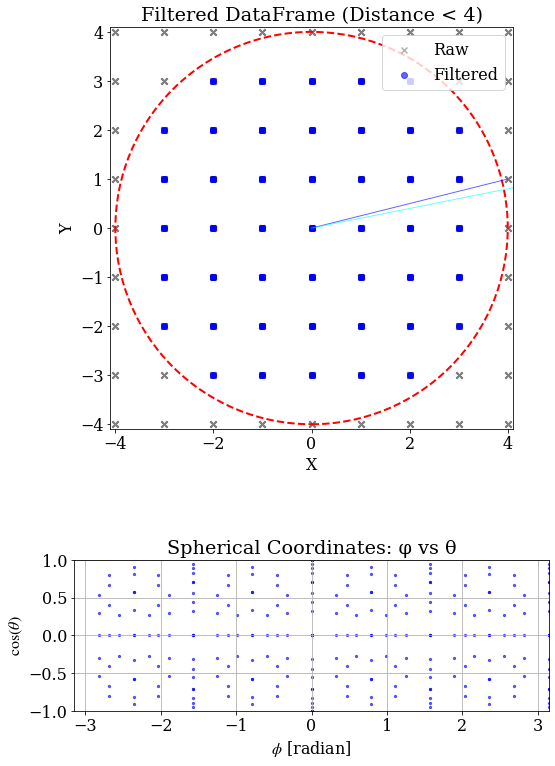

In [51]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

# Plot settings
plt.rc('font', family='serif') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

# --- Create a 2-row, 1-column figure ---
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

# ---------------- Top Panel ----------------
# Plot rawdf and df in XY space
ax1.scatter(rawdf['x'], rawdf['y'], alpha=0.6, color='gray', marker='x', label='Raw')
ax1.scatter(df['x'], df['y'], alpha=0.6, color='blue', label='Filtered')
ax1.plot([0, 4], [0, 1], color='blue', linewidth=1, linestyle='-', alpha=0.6)  # <-- Added blue thin line
ax1.plot([0, 5], [0, 1], color='cyan', linewidth=1, linestyle='-', alpha=0.6)  # <-- Added blue thin line


ax1.set_title('Filtered DataFrame (Distance < 4)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_xlim(-4.1, 4.1)
ax1.set_ylim(-4.1, 4.1)
ax1.set_aspect('equal')
circle = Circle((0, 0), 4.0, color='red', fill=False, linewidth=2, linestyle='--')
ax1.add_patch(circle)
ax1.legend()

# ---------------- Bottom Panel ----------------
# If not already done:
# df['phi'] = np.mod(np.arctan2(df['y'], df['x']), 2 * np.pi)
# df['costheta'] = df['z'] / np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)

ax2.scatter(df['phi'], df['costheta'], s=5, c='blue', alpha=0.6)
ax2.set_xlabel(r'$\phi$ [radian]')
ax2.set_ylabel(r'$\cos(\theta)$')
ax2.set_title('Spherical Coordinates: φ vs θ')
ax2.set_xlim(-np.pi,np.pi)  # match with phi normalization
ax2.set_ylim(-1, 1)
ax2.grid(True)
ax2.set_aspect('equal')  # Or 'equal' if you really want 1:1

# ---------------- Final Layout ----------------
plt.tight_layout()

plt.savefig("tng50-100Mpc-extension-avoiding-zone.pdf", format='pdf', bbox_inches='tight')
plt.savefig("tng50-100Mpc-extension-avoiding-zone.png", format='png', dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

Two Crop Lines for $N=4$ duplicated boxes

- upper line: 0/4, 1/4, 2/4, 3/4, 4/4
- lower line: 0/5, 1/5, 2/5, 3/5, 4/5 

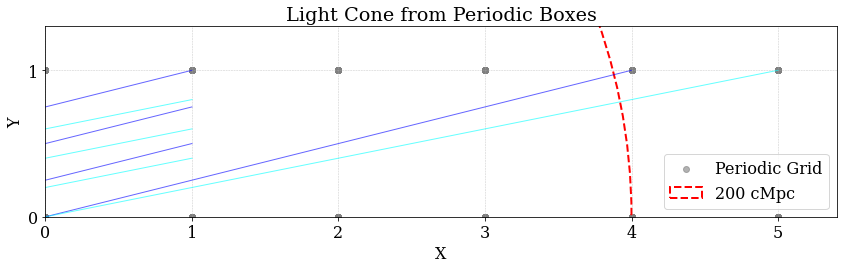

In [73]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.ticker import MultipleLocator

# Create a single-panel figure
fig, ax = plt.subplots(figsize=(12, 4))

# Scatter plots
ax.scatter(rawdf['x'], rawdf['y'], alpha=0.6, color='gray', label='Periodic Grid')
#ax.scatter(df['x'], df['y'], alpha=0.6, color='blue', label='Filtered')

# Add lines
ax.plot([0, 4], [0, 1], color='blue', linewidth=1, linestyle='-', alpha=0.6)
ax.plot([0, 5], [0, 1], color='cyan', linewidth=1, linestyle='-', alpha=0.6)

ax.plot([0, 1], [0.25, 0.5], color='blue', linewidth=1, linestyle='-', alpha=0.6)
ax.plot([0, 1], [0.5, 0.75], color='blue', linewidth=1, linestyle='-', alpha=0.6)
ax.plot([0, 1], [0.75, 1.0], color='blue', linewidth=1, linestyle='-', alpha=0.6)

ax.plot([0, 1], [0.2, 0.4], color='cyan', linewidth=1, linestyle='-', alpha=0.6)
ax.plot([0, 1], [0.4, 0.6], color='cyan', linewidth=1, linestyle='-', alpha=0.6)
ax.plot([0, 1], [0.6, 0.8], color='cyan', linewidth=1, linestyle='-', alpha=0.6)


# Set plot aesthetics
ax.set_title('Light Cone from Periodic Boxes')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0, 5.4)
ax.set_ylim(0, 1.3)
ax.set_aspect('equal')  # Change to 'equal' only if x and y scales should match

# Set ticks only at integer positions
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))

# Enable grid for major ticks only
ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)


# Optional: Add a circle (though it may go outside your new axes range)
circle = Circle((0, 0), 4.0, color='red', fill=False, linewidth=2, linestyle='--', label='200 cMpc')
ax.add_patch(circle)
#circle1 = Circle((-3, 0), 4.0, color='red', fill=False, linewidth=2, linestyle='--')
#ax.add_patch(circle1)


# Add legend
ax.legend(loc='lower right')

# Show plot
plt.tight_layout()


plt.savefig("tng50-200Mpc-lightcone.pdf", format='pdf', bbox_inches='tight')
plt.savefig("tng50-200Mpc-lightcone.png", format='png', dpi=300, bbox_inches='tight', facecolor='white')


plt.show()